In [1]:
import pandas as pd
import bs4
from bs4 import BeautifulSoup
import time
import requests 
from IPython.display import clear_output
import matplotlib.pyplot as plt

# Сброс ограничений на количество выводимых рядов
#pd.set_option('display.max_rows', None)
 
# Сброс ограничений на число столбцов
#pd.set_option('display.max_columns', None)
 
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)



def date(soup):
    #Получение даты выпуска
    date =[]
    for i in soup.find_all('img', {'class':"attachment-bam-featured size-bam-featured wp-post-image"}):
        for i in [i['alt'].split(' — ')]:
            if len(i)>1:
                date+=[i[0].split(' ')[2]]
            else:
                date+=['-']
    return date

def name(soup):
    #Получение названия передачи
    name =[]
    for i in soup.find_all('img', {'class':"attachment-bam-featured size-bam-featured wp-post-image"}):
        for i in [i['alt'].split(' — ')]:
            if len(i)>1:
                name+=[i[1]]
            else:
                name+=[i[0]]
    return name

def url(soup):
    url = [i['href'] for i in soup.find_all('a', {'aria-hidden':"true"})]
    return url

def description(soup):
    #Получение описания
    try:
        description = [' '.join([tag.contents[0] for tag in BeautifulSoup(requests.get(i['href'] ).text, "html.parser")('p')[2:4]]) for i in soup.find_all('a', {'aria-hidden':"true"})]
    except:
        url_ = [i['href'] for i in soup.find_all('a', {'aria-hidden':"true"})]
        soup_ = [BeautifulSoup(requests.get(i).text, "html.parser") for i in url_]
        _soup = [soup.find_all('div', {'class': "entry-content"}) for soup in soup_]
        description = [' '.join([i.contents[0] for i in soup[0]('p') if type(i.contents[0]) == bs4.element.NavigableString]) for soup in _soup]
    return description

def get_df(soup):
    #Запись все в датафрейм
    df = pd.DataFrame({'Дата выпуска': date(soup),
                       'Название': name(soup),
                       'Ссылка': url(soup),
                       'Описание':description(soup)})
    return df

Возникло ошибок: 0
Среднее время обработки составляет: 3.56295 секунд
Осталось: 0.06 минут


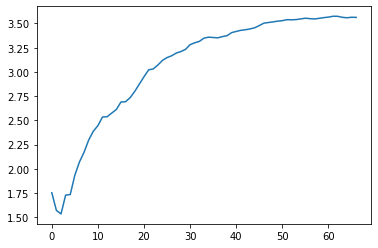

In [4]:
df = pd.DataFrame()
error_list = []
t = []
x = []
y = []
    
for i in range(67):
    start = time.time()
    try:
        soup = BeautifulSoup(requests.get(f'https://m-zh.ru/page/{i}').text, "html.parser")
        df = pd.concat([df, get_df(soup)], ignore_index=True)
    except:
        error_list.append(i)
        print(f'Error with: {i}')
    end = time.time()
    t += [end-start]
    r = round(((sum(t)/len(t))*(67-i))/60, 2)
    
    clear_output(wait=True)
    print(f'Возникло ошибок: {len(error_list)}\nСреднее время обработки составляет: {sum(t)/len(t):.5f} секунд\nОсталось: {r} минут')
    x += [i]
    y += [sum(t)/len(t)]
    plt.plot(x, y)
    plt.show()
    
    

In [445]:
len(df)

536

In [385]:
df.to_csv('МЖ.csv', index = False)

In [383]:
zapros = 'Женщина на грани нервного срыва'

df.loc[df['Название'].str.contains(zapros) == True, 'Оценка_Сережи'] = 1
df.loc[df['Название'].str.contains(zapros) == True, 'Оценка_Алены'] = 3

In [384]:
zapros = 'Женщина на грани нервного срыва'

df.loc[df['Описание'].str.contains(zapros) == True].merge(df.loc[df['Название'].str.contains(zapros) == True], 'outer')

,Дата выпуска,Название,Ссылка,Описание,Оценка_Сережи,Оценка_Алены
0,18.06.2021,Женщина на грани нервного срыва,https://m-zh.ru/muzhskoe-zhenskoe-18-06-2021-zhenshhina-na-grani-nervnogo-sryva.html,"Смотреть онлайн Мужское Женское от 18.06.21 года на Первом канале. Наталья Лохмачева на грани нервного срыва, она утверждает, что 3 месяца назад органы опеки забрали ее сыновей в детский дом из-за досадного недоразумения. Однако бывший муж Натальи Сергей Лохмачев в недоразумения не верит. Мужчина уже три года воспитывает их совместных дочерей и считает экс-жену худшей матерью на свете. За это время Сергей успел лишить Наташу родительских прав и найти для пятерых девочек новую маму. Из-за чего Наталью ограничили в родительских правах? Почему она покинула свою первую семью и бросила дочерей? И сможет ли она вернуть сыновей домой?",1.0,3.0


In [135]:
df['Оценка_Сережи'].value_counts()

3.0    3
5.0    2
6.0    1
Name: Оценка_Сережи, dtype: int64

In [141]:
df['Оценка_Алены'].value_counts()

3.0    3
7.0    2
5.0    1
Name: Оценка_Алены, dtype: int64

In [284]:
A_max = max(df['Оценка_Алены'].value_counts().index)
S_max = max(df['Оценка_Сережи'].value_counts().index)
A_max_df = df.loc[df['Оценка_Алены'] == A_max]
S_max_df = df.loc[df['Оценка_Сережи'] == S_max]
max_list = S_max_df.merge(A_max_df, 'outer')['Описание'].to_list()
r = max_list[0]
m_list = []
for j in max_list:
    for i in ['.', ',', ':', '!', '?']:
        j = j.replace(i, '')
    m_list += (j.split())
dupl_value = pd.DataFrame({'values': m_list})
# len(dupl_value) = 307
#dupl_value = pd.DataFrame({'values': list(dupl_value.value_counts().index), 'dupl':dupl_value.value_counts().to_list()})
# len(dupl_value) = 167

In [443]:
#r = dupl_value.value_counts(normalize=True)
r = dupl_value.value_counts()
dupl = pd.DataFrame({'value':[i[0] for i in r.index.tolist()], 'dupl':r})
for i in dupl.index:
    if len(i[0]) < 3:
        dupl = dupl.sort_index(axis=0).drop([i[0]], axis = 0)

dupl.loc[dupl.value == 'дети', 'dupl'] = sum(dupl.loc[dupl.value.str.contains('дет') == True, 'dupl'])

for i in ['что', 'она', 'канале', 'онлайн', 'все', 'детей', 'ведь', 'кому', 'сама', 'них', 'чтобы', 'своих', 'отец', 'мать',
         'могут', 'давно', 'узнаем', 'студии', 'потому', 'считает', 'уверены']:
    dupl = dupl.sort_index(axis=0).drop([i], axis = 0)


for j in ['год', 'лет', 'бабуш', 'себ']:
    for i in dupl.loc[dupl.value.str.contains(j) == True, 'value']:
        dupl = dupl.sort_index(axis=0).drop([i], axis = 0)
        
dupl.loc[dupl.value.str.contains('пьян') == True, 'value'] = 'алкоголь'

for i in ['издеваются', 'изнасиловать', 'избивает', 'заставляет']:
    dupl.loc[dupl.value.str.contains(i) == True, 'value'] = 'насилие'

for j in ['алк', 'видео', 'насилие']:
    sum_ = sum(dupl.loc[dupl.value.str.contains(j) == True,'dupl'].tolist())

    for i in dupl.loc[dupl.value.str.contains(j) == True].index:

        dupl = dupl.sort_index(axis=0).drop([i[0]], axis = 0)
    dupl.loc[j, 'dupl'] = sum_
    dupl.loc[j, 'value'] = j

non_dupl = dupl.loc[dupl.dupl == 1]
for i in dupl.loc[dupl.dupl == 1, 'value']:
    dupl = dupl.sort_index(axis=0).drop([i], axis = 0)
    
r_ = [word for word in dupl.value if word[0].isupper()]
r_.remove('ДНК')
for i in r_:
    dupl = dupl.sort_index(axis=0).drop([i], axis = 0)
    
dupl = dupl.sort_values('dupl', ascending=False)

#dupl.loc[dupl.dupl == max(dupl.dupl)]

#len(dupl) = 135
#len(dupl) = 134
#len(dupl) = 64
#len(dupl) = 55
#len(dupl) = 40


'''
задача объединить однокоренные слова
как то выделить слово #скандальное#
'''

dupl

,value,dupl
values,,
дети,дети,8.0
насилие,насилие,6.0
алк,алк,5.0
проститутка,проститутка,2.0
ополчилось,ополчилось,2.0
отличной,отличной,2.0
покончила,покончила,2.0
помощи,помощи,2.0
попытках,попытках,2.0


In [442]:
non_dupl.sort_values('value', ascending=True)

,value,dupl
values,,
(повтор,(повтор,1.0
16042021),16042021),1.0
160421,160421,1.0
2020,2020,1.0
2022,2022,1.0
«Мужского/Женского»,«Мужского/Женского»,1.0
«Мужское/Женское»,«Мужское/Женское»,1.0
Давно,Давно,1.0
Диму,Диму,1.0


In [432]:
dupl.loc[dupl.value.str.contains('насил') == True]

,value,dupl
values,,
насилие,насилие,2.0
